# Packages

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'lines.linewidth' : 1.5,
    'lines.markersize' : 10,
    'figure.figsize': (8,5),
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12,
    'font.family': 'serif',
    'legend.fontsize':12,
    'axes.labelsize':18
})

# Importing Kuramoto dataset

We first import the solution obtained from the Kuramoto differential equation subject to periodic boundary conditions. The spatial domain has length L=200 and discretized with 256 nodes. The time step was 0.25 s with a time domain from t=0 to t=2000 s.

$$ u_t + u_x u + u_{xx} + u_{xxxx}=0 \tag{1}$$ 


$$ u(t=0,x) = cos \frac{\pi x}{20}*(1+sin\frac{\pi x}{20})  \tag{2}$$


The first 100 seconds were truncated in order to view the more chaotic part of the solution

In [9]:
X = np.load('Kuramoto_dataset\Kuramoto_X.npy')
T = np.load('Kuramoto_dataset\Kuramoto_T.npy')
U = np.load('Kuramoto_dataset\Kuramoto_U.npy')

In [10]:
X.shape

(40001, 256)

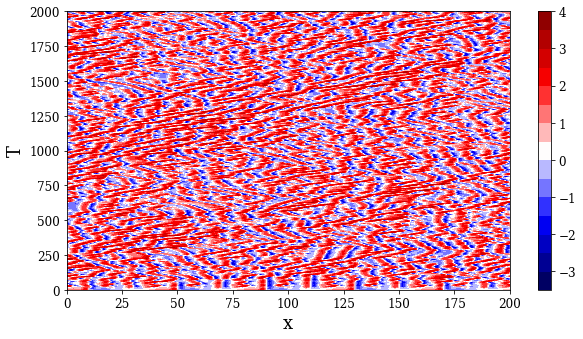

In [11]:
fig, ax = plt.subplots(figsize=(9, 5))

surf = plt.contourf(X, T, U,15, cmap=plt.get_cmap("seismic"))

plt.colorbar(surf)
plt.xlabel('x')
plt.ylabel('T')
plt.tight_layout()

In [12]:
# Taking out the first 300 seconds of data to avoid any transients

X = X[6000:]
T = T[6000:]
U = U[6000:]

## Creating the training and test set for evaluating PCA

In [13]:
# 75% training and 25% testing

X_train = X[:30000]
T_train = T[:30000]
U_train = U[:30000]

X_test = X[30000:]
T_test = T[30000:]
U_test = U[30000:]

In [14]:
print(U_train.shape)
print(U_test.shape)

(30000, 256)
(4001, 256)


In [15]:
# Normalizing the dataset to be with 0 mean and unit variance

scaler = StandardScaler()

U_scaled_train = scaler.fit_transform(U_train)
U_scaled_test = scaler.transform(U_test)

# Applying dimensionality reduction for the Kuramoto dataset

## Principal component analysis (PCA)

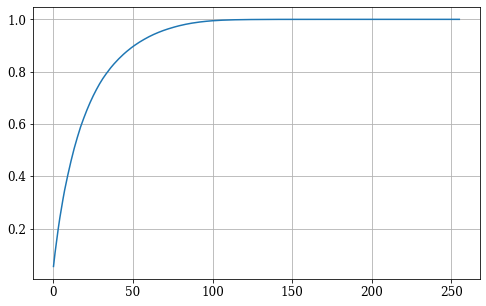

In [16]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(U_scaled_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) # Cumulative sum of the variance explained by each dimension 

plt.plot(cumsum)
plt.grid()

In [17]:
d = np.argmax(cumsum >= 0.99) + 1
print(str(d) + ' components')
pca = PCA(n_components=d) # Reduce number of components from 256 to 93
U_train_pca = pca.fit_transform(U_scaled_train)
U_test_pca = pca.transform(U_scaled_test)

94 components


It turns out that I need 93 components for 99% explained variance. We reduced 256 columns to a representation with 93 eigenvectors with associated eigenvalues

In [18]:
U_train_reduced = pca.inverse_transform(U_train_pca)
U_test_reduced = pca.inverse_transform(U_test_pca)
print(U_train_reduced.shape)

U_train_reduced_inverse = scaler.inverse_transform(U_train_reduced)  # Apply inverse transform to obtain dataset in same scale as the original data
U_test_reduced_inverse = scaler.inverse_transform(U_test_reduced)

(30000, 256)


0.09925258731247988


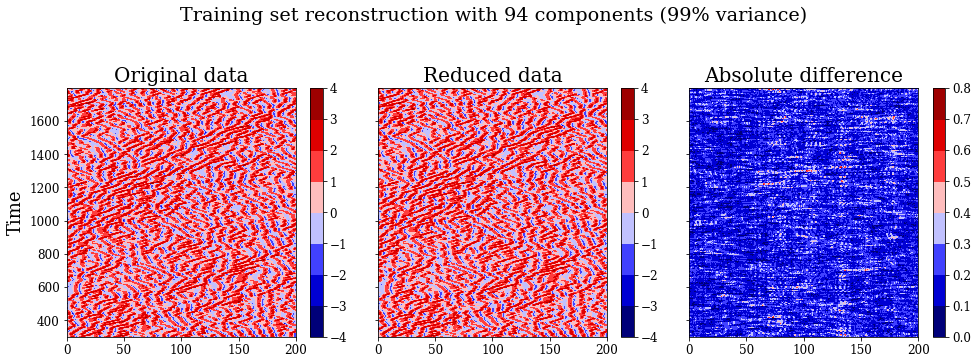

In [19]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(14, 5))
plt.suptitle('Training set reconstruction with 94 components (99% variance)', y=1.02)

surf1 = ax[0].contourf(X_train, T_train, U_train, cmap=plt.get_cmap("seismic"))
fig.colorbar(surf1, ax=ax[0], ticks=None)
ax[0].set_title('Original data')
ax[0].set_ylabel('Time')

surf2 = ax[1].contourf(X_train, T_train, U_train_reduced_inverse,cmap=plt.get_cmap("seismic"))
fig.colorbar(surf2, ax=ax[1])
ax[1].set_title('Reduced data')

surf3 = ax[2].contourf(X_train, T_train, abs(U_train-U_train_reduced_inverse),cmap=plt.get_cmap("seismic")) # 
fig.colorbar(surf3, ax=ax[2])
ax[2].set_title('Absolute difference')

plt.tight_layout()

print(abs(U_train-U_train_reduced_inverse).mean())

0.16870030904210137


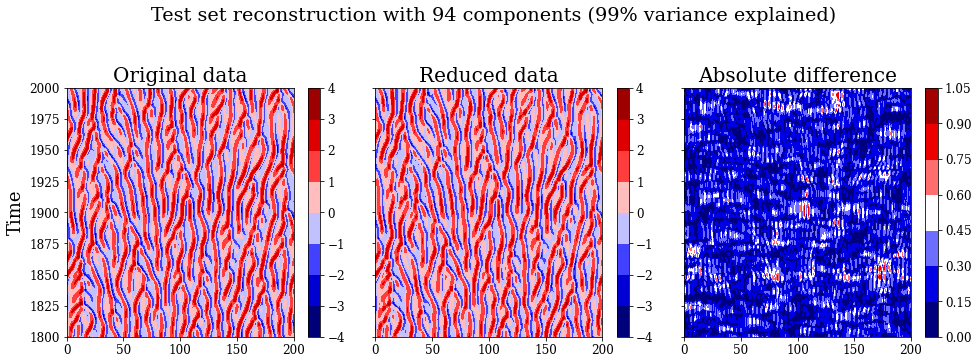

In [20]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(14, 5))
plt.suptitle('Test set reconstruction with 94 components (99% variance explained)', y=1.02)

surf1 = ax[0].contourf(X_test, T_test,U_test, cmap=plt.get_cmap("seismic"))
fig.colorbar(surf1, ax=ax[0], ticks=None)
ax[0].set_title('Original data')
ax[0].set_ylabel('Time')

surf2 = ax[1].contourf(X_test, T_test, U_test_reduced_inverse,cmap=plt.get_cmap("seismic"))
fig.colorbar(surf2, ax=ax[1])
ax[1].set_title('Reduced data')

surf3 = ax[2].contourf(X_test, T_test, abs(U_test-U_test_reduced_inverse),cmap=plt.get_cmap("seismic"))
fig.colorbar(surf3, ax=ax[2])
ax[2].set_title('Absolute difference')

plt.tight_layout()

print(abs(U_test-U_test_reduced_inverse).mean())

Using Standardcaler: 

Training set error: 0.1018 

Test ser error: 0.1809

From the above plot, we consider the precision to be sufficient for this application.

## Final ROM from Kuramoto equation

In [21]:
scaler = StandardScaler()
U_scaled = scaler.fit_transform(U)

pca = PCA(n_components=d)
U_pca = pca.fit_transform(U_scaled)
U_pca.shape

(34001, 94)

In [22]:
df = pd.DataFrame(U_pca)
df

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,6.677109,-5.978096,2.577128,3.304686,-3.736464,-0.074265,-3.493094,1.664380,3.546049,-1.973562,...,-0.222106,-0.581925,-0.227523,1.010808,0.166362,0.507885,-1.096224,0.932209,0.598374,0.069739
1,6.682495,-5.987902,2.547367,3.372001,-3.782339,-0.075114,-3.480440,1.681142,3.513415,-1.990802,...,-0.240814,-0.579845,-0.227171,1.008430,0.182347,0.504531,-1.092278,0.924466,0.588964,0.046874
2,6.687168,-5.997976,2.518633,3.438409,-3.826708,-0.076127,-3.467654,1.697629,3.479227,-2.006757,...,-0.259024,-0.576902,-0.226756,1.005792,0.198606,0.501043,-1.088617,0.916289,0.579496,0.024725
3,6.691120,-6.008337,2.490907,3.503894,-3.869574,-0.077293,-3.454737,1.713832,3.443537,-2.021472,...,-0.276722,-0.573100,-0.226258,1.002906,0.215095,0.497445,-1.085271,0.907693,0.569957,0.003324
4,6.694344,-6.019005,2.464172,3.568447,-3.910938,-0.078604,-3.441687,1.729745,3.406396,-2.034995,...,-0.293898,-0.568444,-0.225659,0.999780,0.231774,0.493764,-1.082267,0.898693,0.560337,-0.017301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33996,2.855421,-0.621361,1.351222,-1.553371,-2.786034,-2.911797,1.980202,7.583428,-1.217830,1.964478,...,0.396017,0.958522,-0.805695,0.312976,-1.295745,-0.659188,-0.842671,-0.417175,0.174258,-0.439271
33997,2.797995,-0.619598,1.381212,-1.590193,-2.786908,-2.961349,1.987868,7.581834,-1.236074,2.007303,...,0.381974,0.952310,-0.811024,0.314052,-1.316608,-0.662581,-0.853659,-0.416846,0.166436,-0.445483
33998,2.740946,-0.617536,1.412142,-1.626961,-2.787288,-3.010079,1.996612,7.580036,-1.253666,2.048377,...,0.367663,0.945189,-0.816625,0.314904,-1.337814,-0.665910,-0.863991,-0.416178,0.158393,-0.451094
33999,2.684333,-0.615140,1.443966,-1.663629,-2.787196,-3.057906,2.006431,7.578022,-1.270522,2.087600,...,0.353096,0.937190,-0.822495,0.315531,-1.359290,-0.669203,-0.873640,-0.415213,0.150149,-0.456109


# Plotting a sample of all time series

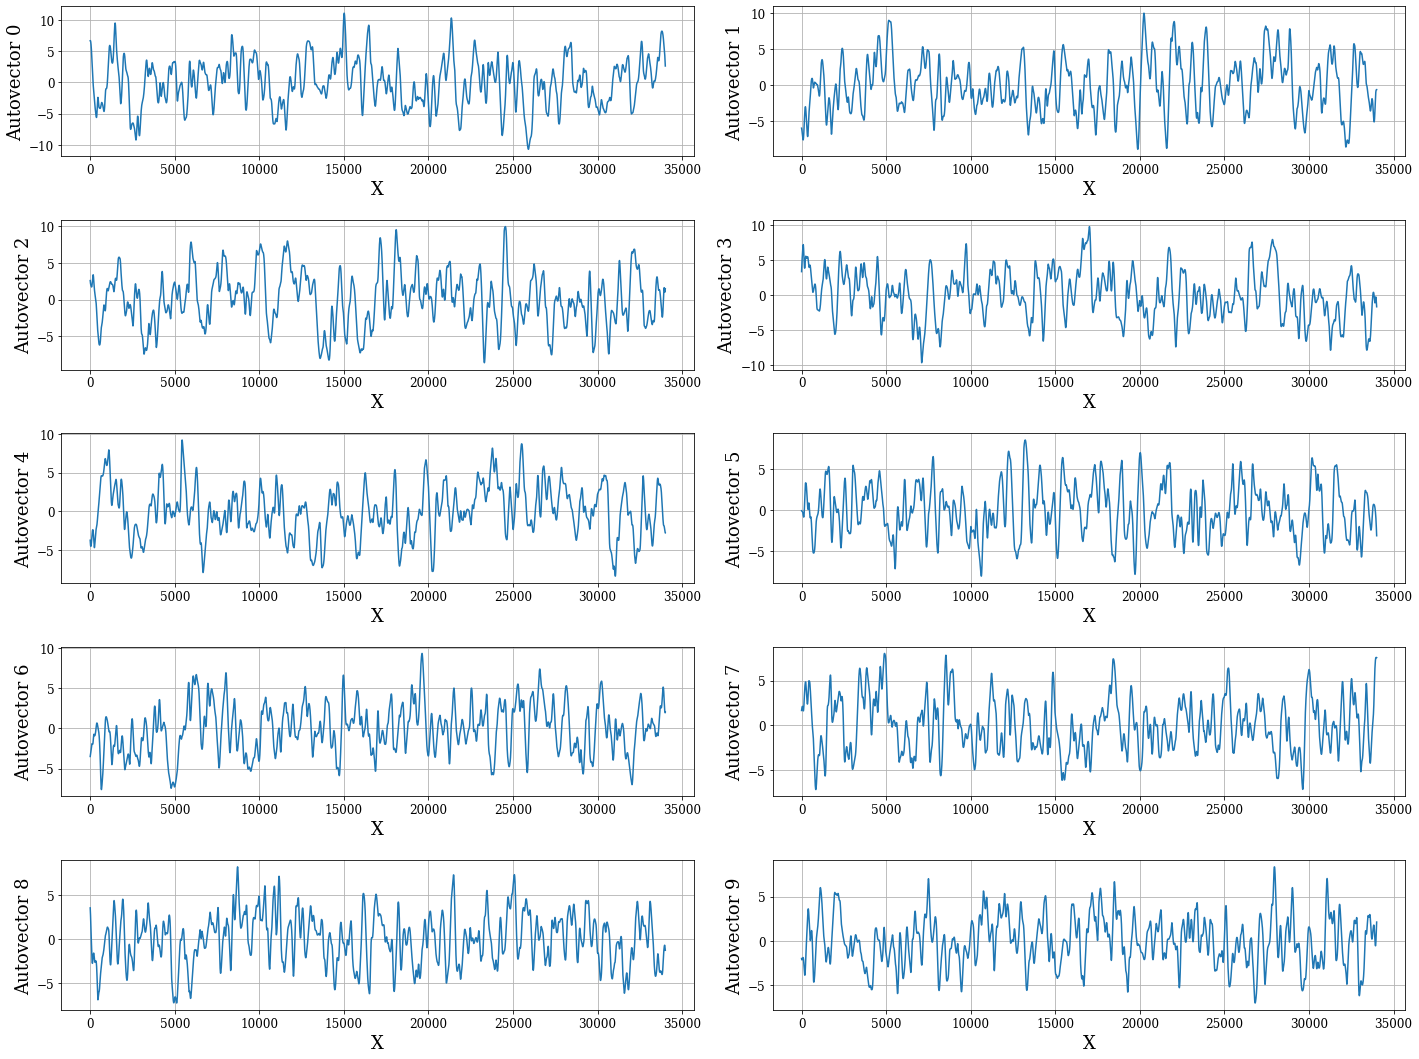

In [23]:
plt.rcParams.update({'figure.figsize': (20, 15)})

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(df[df.columns[i]], label = df.columns[i])
    
    plt.xlabel('X')
    plt.ylabel('Autovector ' + str(df.columns[i]))
    plt.tight_layout()
    plt.grid()

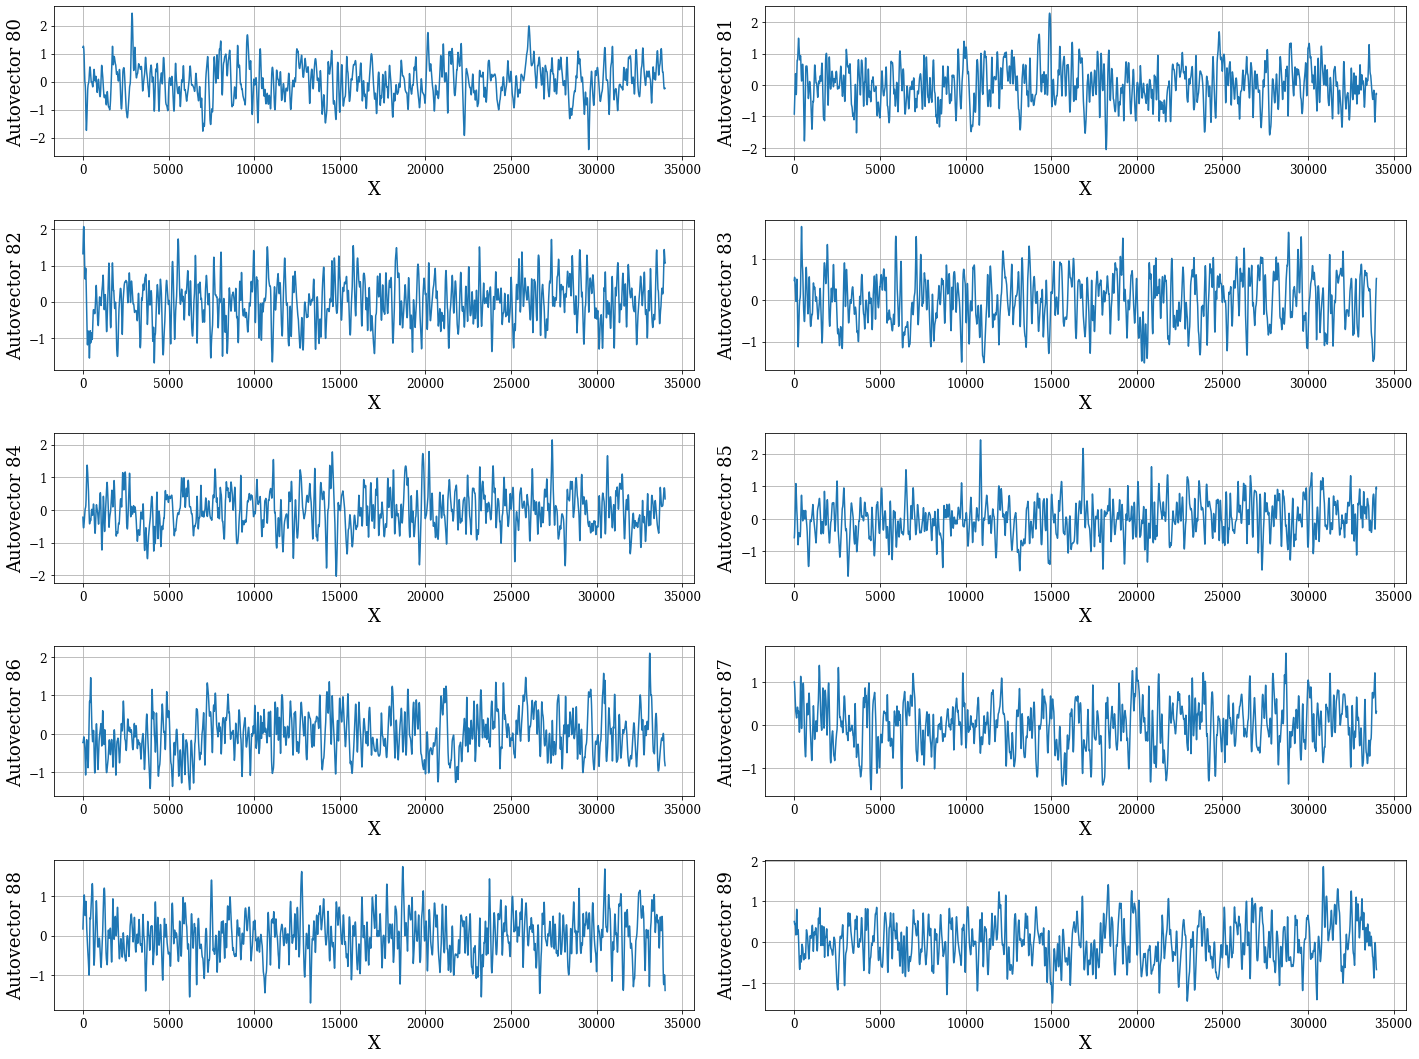

In [24]:
plt.rcParams.update({'figure.figsize': (20, 15)})

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(df[df.columns[i+80]], label = df.columns[i])
    
    plt.xlabel('X')
    plt.ylabel('Autovector ' + str(df.columns[i+80]))
    plt.tight_layout()
    plt.grid()

The time series seem to be random values around 0. Is there some pattern in this data? If so, the selection of forecasting model would be easier.

We can see that the amplitude of the first few time series (which corresponds to the most important eigenvectors) have larger amplitude and lower frequency compared last eigenvectors (lower amplitude/energy and higher frequency).

# Statistical analysis of time series 

Statistical analysis has the objective of better understanding the behavior of our time series in order to better define our model

## Dickey-Fuller Test - visualize stationarity

This is the statistical test that we run to determine if a time series is stationary or not. Without going into the technicalities of the Dickey-Fuller test, it tests the null hypothesis that a unit root is present.

- If it is, then p > 0.05, and the process is not stationary.
- Otherwise, p < 0.05, the null hypothesis is rejected, and the process is considered to be stationary.

When the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary.

In [25]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

In [26]:
# Augmented Dickey-Fuller Test

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Lags used = {:.3f}'.format(dftest[2]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

for i in range(10):
    ADF_test(df[df.columns[i]],'Autovector ' + str(i))
    print('')

 > Is the Autovector 0 stationary?
Test statistic = -0.667
P-value = 0.855
Lags used = 8.000
Critical values :
	1%: -3.430542392147882 - The data is not stationary with 99% confidence
	5%: -2.8616250324956867 - The data is not stationary with 95% confidence
	10%: -2.5668152601387706 - The data is not stationary with 90% confidence

 > Is the Autovector 1 stationary?
Test statistic = -0.401
P-value = 0.910
Lags used = 8.000
Critical values :
	1%: -3.430542392147882 - The data is not stationary with 99% confidence
	5%: -2.8616250324956867 - The data is not stationary with 95% confidence
	10%: -2.5668152601387706 - The data is not stationary with 90% confidence

 > Is the Autovector 2 stationary?
Test statistic = -22.349
P-value = 0.000
Lags used = 7.000
Critical values :
	1%: -3.430542386487697 - The data is  stationary with 99% confidence
	5%: -2.861625029994108 - The data is  stationary with 95% confidence
	10%: -2.5668152588072446 - The data is  stationary with 90% confidence

 > Is t

In [27]:
# Visualizing stationarity for the least important eigenvectors
for i in range(10):
    ADF_test(df[df.columns[i+80]],'Autovector' + str(i+80))
    print('')

 > Is the Autovector80 stationary?
Test statistic = -3.827
P-value = 0.003
Lags used = 8.000
Critical values :
	1%: -3.430542392147882 - The data is  stationary with 99% confidence
	5%: -2.8616250324956867 - The data is  stationary with 95% confidence
	10%: -2.5668152601387706 - The data is  stationary with 90% confidence

 > Is the Autovector81 stationary?
Test statistic = -2.556
P-value = 0.102
Lags used = 8.000
Critical values :
	1%: -3.430542392147882 - The data is not stationary with 99% confidence
	5%: -2.8616250324956867 - The data is not stationary with 95% confidence
	10%: -2.5668152601387706 - The data is not stationary with 90% confidence

 > Is the Autovector82 stationary?
Test statistic = -2.760
P-value = 0.064
Lags used = 8.000
Critical values :
	1%: -3.430542392147882 - The data is not stationary with 99% confidence
	5%: -2.8616250324956867 - The data is not stationary with 95% confidence
	10%: -2.5668152601387706 - The data is  stationary with 90% confidence

 > Is the 

We can see that our dataset has both stationary and non stationary signals. If traditional time series forecasting algorithms are to be used, they must be the ones that deal with non stationary signals like ARIMA (Autoregressive Integrated Moving Average) or SARIMA (Seasonal Autoregressive Integrated Moving Average). 

Machine learning algorithms should also be able to deal with non stationary signals.

## Detecting the presence of white noise

A time series can be summarized by the following formula:

y(t) = signal(t) + noise(t)

It is expected that a time series signal contains white noise. Therefore, it is an important concept for time series analysis to confirm if the signal has this for two main reasons:

- **Predictability:** if the time series is white noise, then it is, by definition, random. You cannot reasonably model it and make predictions
- **Model diagnostics:** The errors of a model should, ideally be white noise. This means that all signal information in the time series has been harnessed by the model in order to make the predictions. If the model output is not white noise, it is an indication that further improvements can be made. 

The time series in not white noise if any of the following conditions are true:

- Time series have non-zero mean;
- The variance change over time;
- There exists correlation with lag values.

In [28]:
df.mean()

0    -2.891197e-16
1     7.645848e-16
2    -1.002365e-15
3     2.010790e-15
4     1.256931e-15
          ...     
89    5.774590e-16
90    6.403643e-16
91    2.853320e-16
92   -3.543377e-16
93    2.621159e-16
Length: 94, dtype: float64

The time series appear to all have zero mean. The standard deviation case is harder to do so lets look at the lag values and visualize autocorrelation

In [29]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, .pacf_yw
from tqdm import tqdm

100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


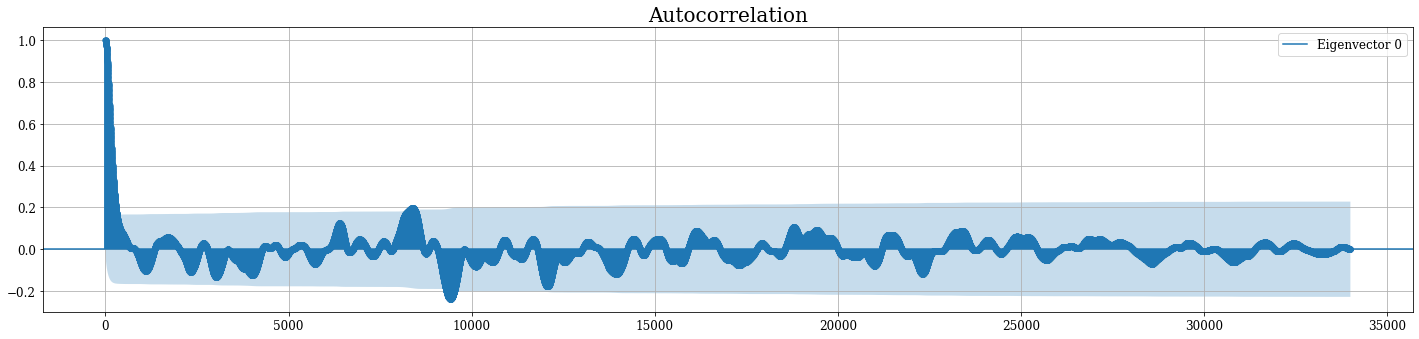

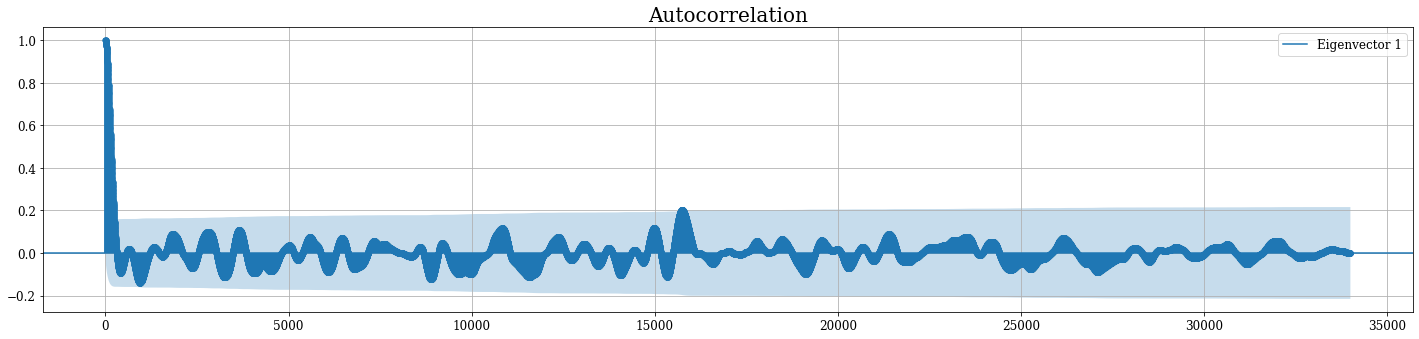

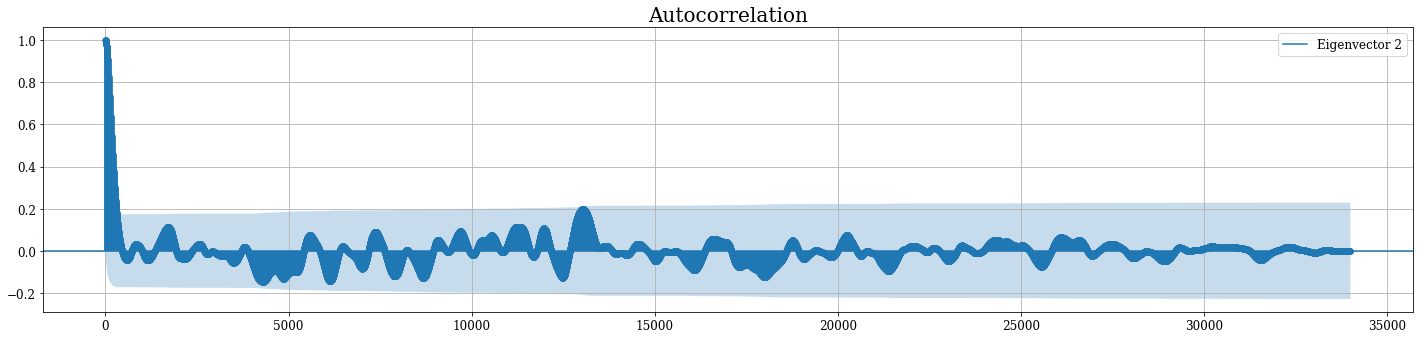

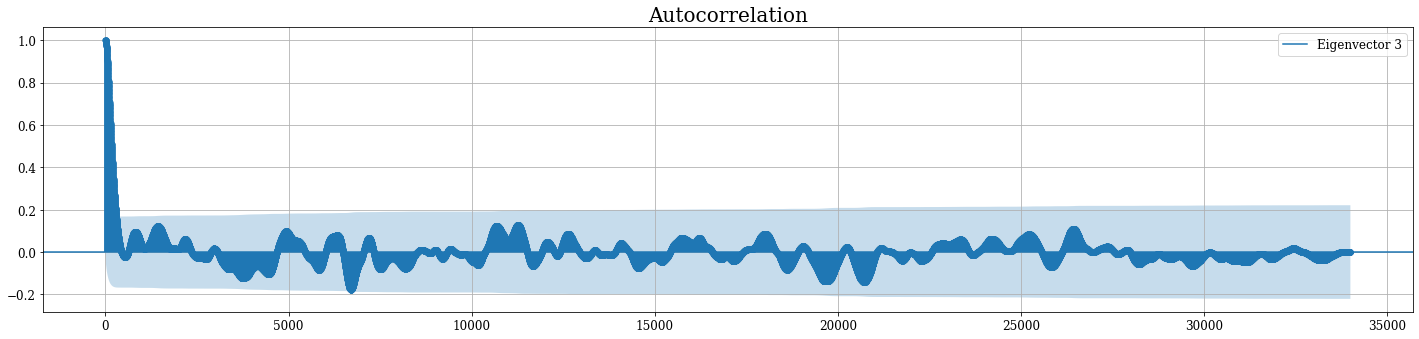

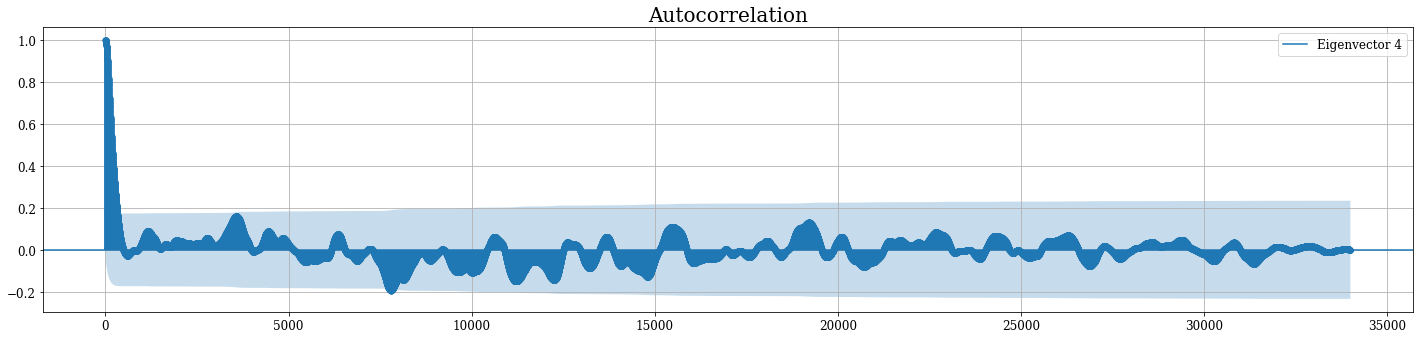

In [30]:
plt.rcParams.update({'figure.figsize': (20, 5)})

for i in tqdm(range()):
    plot_acf(df[df.columns[i]],lags=len(df)-1)
    plt.tight_layout()
    plt.legend(['Eigenvector ' + str(i)])
    plt.grid()

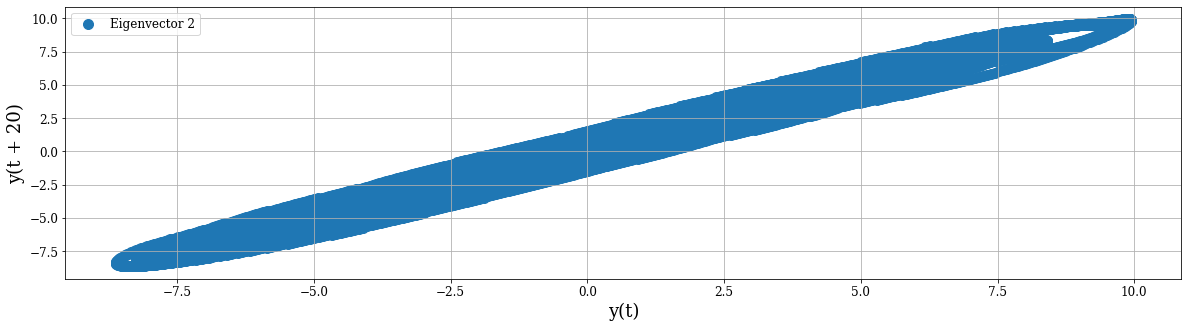

In [43]:
from pandas.plotting import lag_plot

lag_plot(df[df.columns[2]],lag=20)
plt.legend(['Eigenvector 2'])
plt.grid()


The confidence interval of 95% is represented by the shaded cone. Values outside the cone suggest very likely correlation and not a statistical fluke. Looks like the first lags have autocorrelation when compared to the others. 

Let us now look at the partial autocorrelation if the residuals of the autocorrelation above are related (leftover errors). In this case we calculate the residual (error) for the series at time **t** and time **t-k**, where k is the lag number and see the autocorrelation for the time series at k-1. 

In doing so, we see if we can correct the residual error by using a lagged version of the time series.

100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


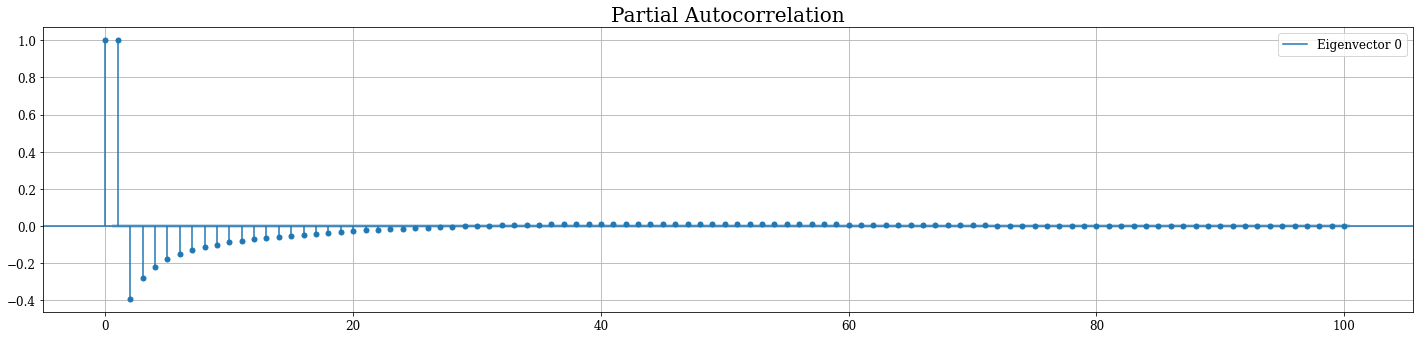

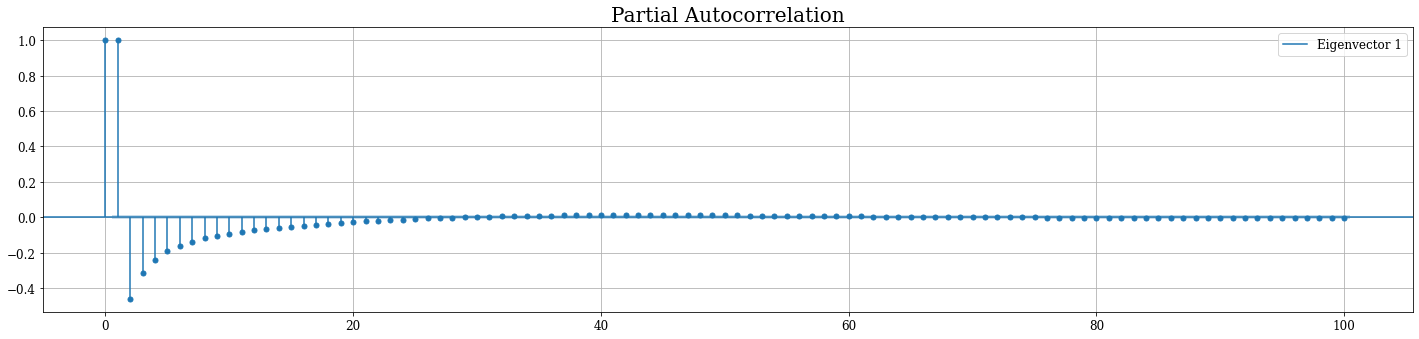

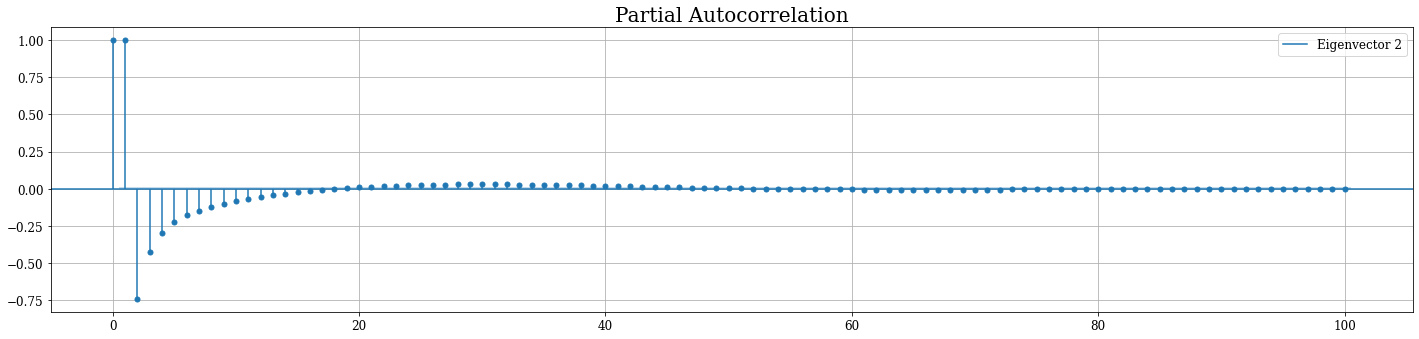

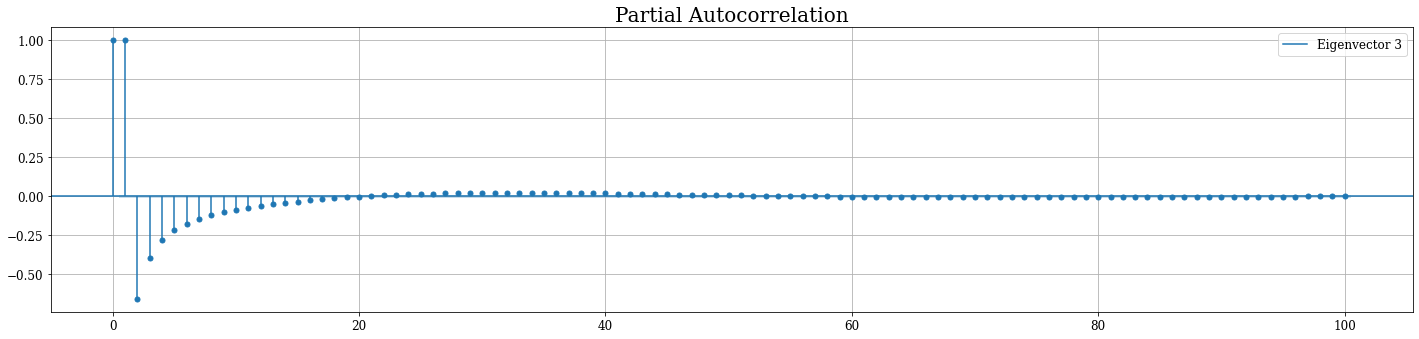

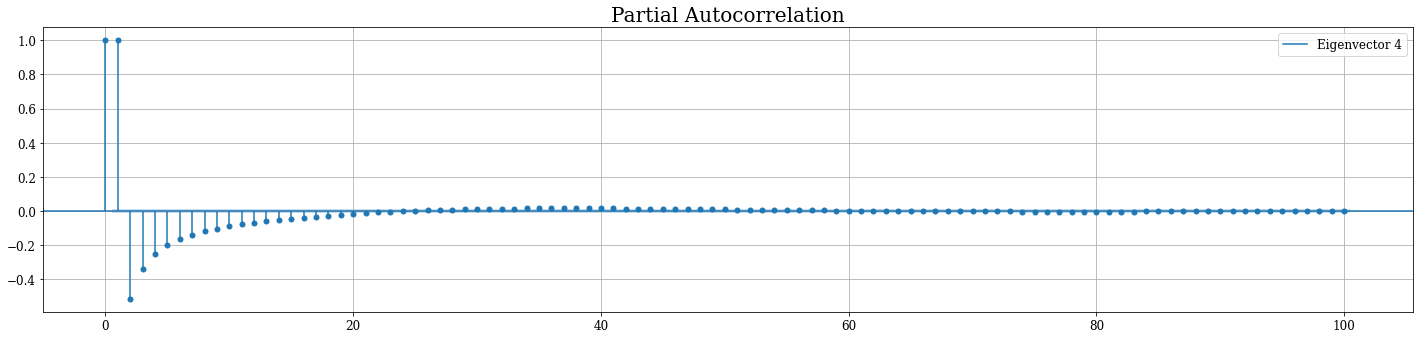

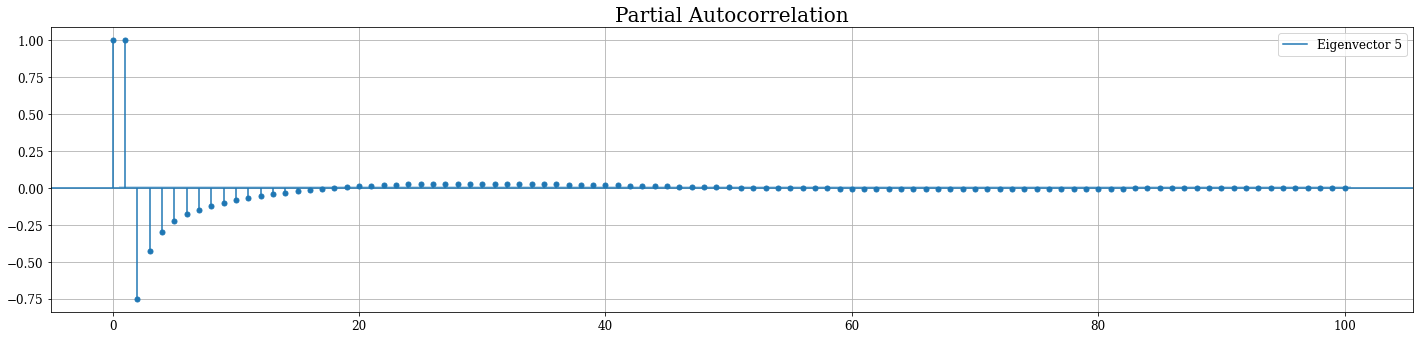

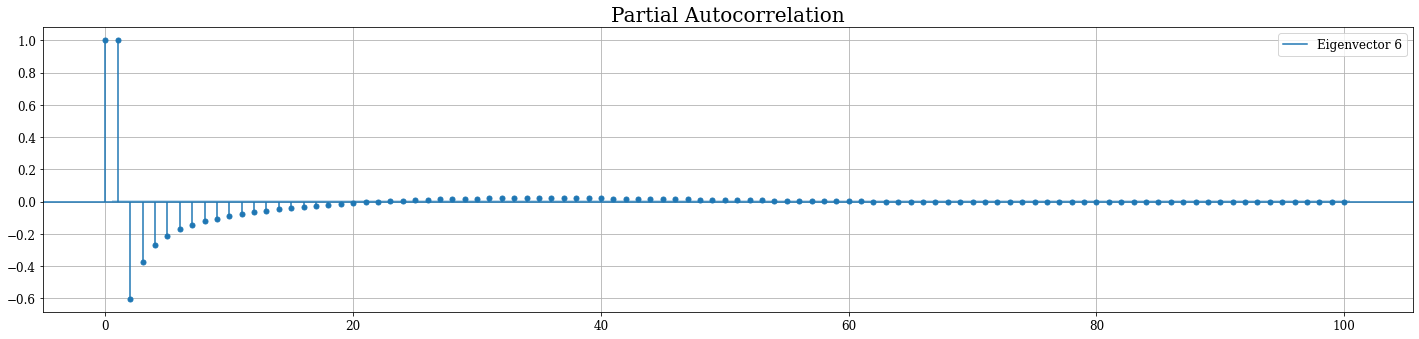

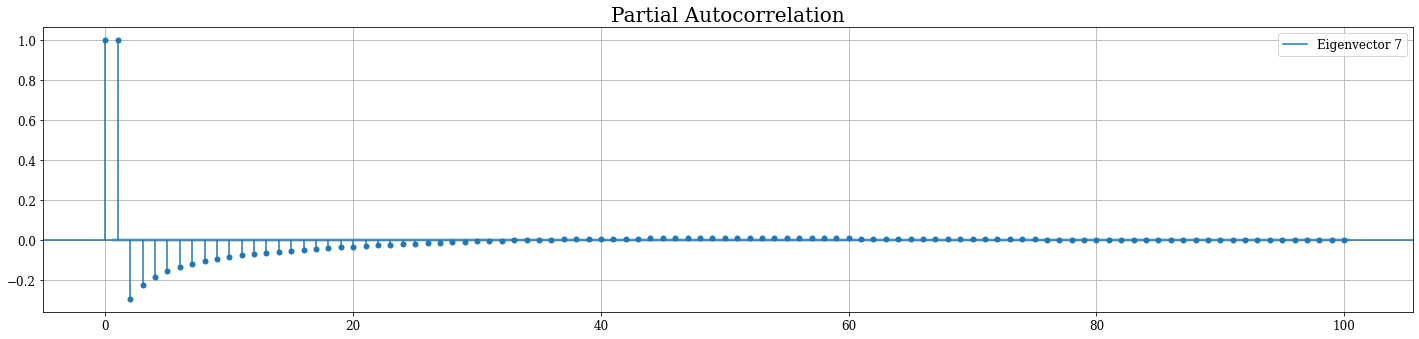

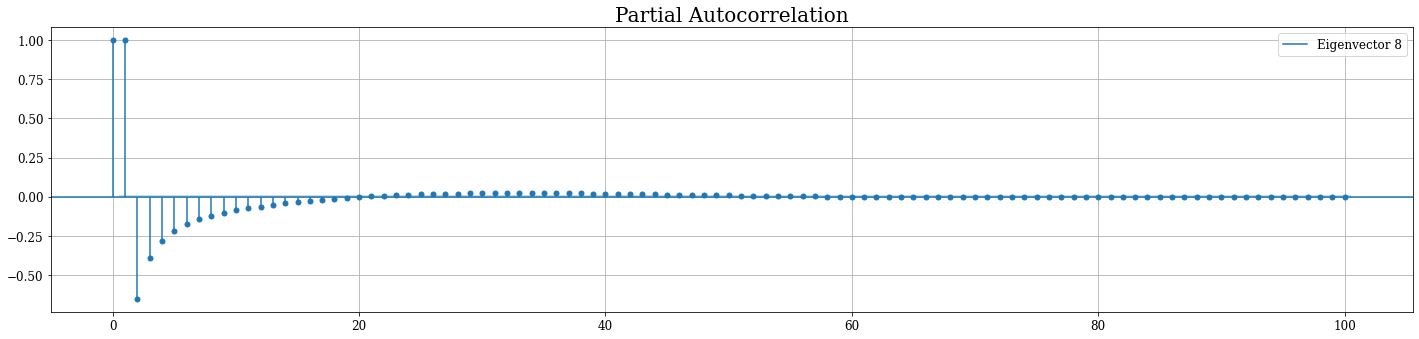

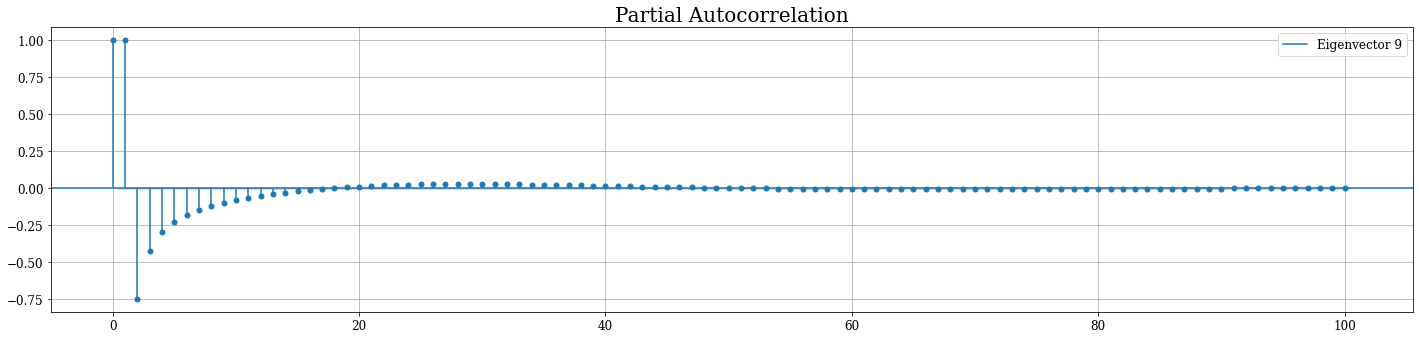

In [61]:
plt.rcParams.update({'figure.figsize': (20, 5)})

for i in tqdm(range(10)):
    plot_pacf(df[df.columns[i]], lags=100,method='ywmle')
    plt.tight_layout()
    plt.legend(['Eigenvector ' + str(i)])
    plt.grid()

# Creating the dataset for typical ML models

We must frame our time series forecasting problem as a supervised learning problem. Given an input dataset **X** and an output variable **y**, we will try to find a mapping function from the input to the output. This involves using the value at previous time steps to predict the value at the next time step.

To do so, our dataset **X** must be the data as a previous time step while **y** must be the data at the next time step. The order between observations must be conserved since the order matters.

We must employ a sliding window to convert the problem into supervised learning. Note that we are working with a **multivariate time series**, meaning that two or more variables (eigenvectors in this case) are observed at each time.

We also want to forecast multiple time steps into the future instead of just one time step. 



In [ ]:
from tqdm import tqdm

y2 = df
X2 = df.shift(1) # atraso o dado com o valor de K

for K in tqdm(range(len(y2))):
    y2 = y2.rename(columns={K: 'Lag ' + str(K)}) # Renaming y columns to differ from X columns
    X2 = X2.rename(columns={K: 'Autovector ' + str(K)}) # Renaming y columns to differ from X columns

In [ ]:
X2

In [ ]:
y2

In [ ]:
# Due to the time shift, a line of NaN appeared in the place where there will be no number. The first line of both dataframes X and y must be removed

X2 = X2.drop(0,axis=0)
y2 = y2.drop(0,axis=0) 

In [ ]:
X2.head()

In [ ]:
y2.head()

# Training traditional ML algorithms

PyCaret Regression Module is a supervised machine learning module used for estimating the relationships between a dependent variable (often called the ‘outcome variable’, or ‘target’) and one or more independent variables (often called ‘features’, or ‘predictors’).

In [ ]:
from pycaret.regression import *

## Test 1 

In [ ]:
df = pd.concat([X2,y2['Lag 6']],axis=1)
df

Autovector 'Lag 6' mas arbitrarily selected as an example. Given the dataframe X, predict the future values of the 6th autovector at time t + dt

### Setup the enviroment

In [ ]:
clf1 = setup(data = df, 
             target = 'Lag 6', 
             data_split_shuffle = False,
             use_gpu = True,
             fold_strategy = 'timeseries',
             preprocess = False,
             train_size = 0.8, 
             silent=True,
             session_id = 123) # testing for predicting one time series

In [ ]:
models()

### Training the models 

In [ ]:
# Training all models from the above list with the exception of three and get the best 3
top3 = compare_models(sort = 'MAE',
                      exclude=['xgboost','gbr','lar','lightgbm','ada','knn','llar'],
                      n_select = 3) 

In [ ]:
top3

In [ ]:
best = top3[0]

In [ ]:
prediction_holdout = predict_model(best)

In [ ]:
# generate predictions on the original dataset
predictions = predict_model(best, data=df)

plt.figure(figsize=(12,5))
plt.plot(predictions.index,predictions['Label'],color='blue',label='Prediction')
plt.plot(predictions.index,predictions['Lag 6'],color='red',alpha=0.7,label='Real value')
plt.legend()
plt.grid()

In [ ]:
evaluate_model(best)

In [ ]:
plot_model(estimator = best, plot = 'learning')

In [ ]:
plot_model(estimator = best, plot = 'feature')

In [ ]:
plot_model(estimator = best, plot = 'residuals')

In [ ]:
plot_model(estimator = best, plot = 'error')

In [ ]:
#tuned_model = tune_model(best, 
#                         n_iter=5, 
#                         optimize='MSE',
#                         fold=3,
#                        #search_library = 'optuna',
#                         early_stopping=True)

#print(tuned_model)

### Model ready for deployment

In [ ]:
#final_model = finalize_model(best)
#print(final_model)

## Predicting multiple time series

Let's see if the result of pycaret for different time series will result in different models

In [ ]:
#all_results = []
#final_model = {}

#for i in tqdm(range(5)):
    
#    df_new = pd.concat([X,y[y.columns[i]]],axis=1) # create a new dataframe with X and 1 column from y
    
    # initialize setup from pycaret.regression
#    s = setup(df_new, target = y.columns[i], 
#              train_size = 0.70,
#              data_split_shuffle = False, 
#              fold_strategy = 'timeseries', 
#              fold = 5,
#              silent=True,
#              session_id = 123,
#              verbose=False)
    
    # compare all models and select best one based on MAE
#    best_model = compare_models(sort = 'MAE', 
#                                exclude=['xgboost','gbr','lar','lightgbm','ada'],
#                                verbose=False);
    
    # capture the compare result grid and store best model in list
#    p = pull().iloc[0:1]
    #print(p)
#    p['time_series'] = str(i)
    #print(p)
#    all_results.append(p)
    #print(all_results)
    
    # finalize model i.e. fit on entire data including test set
#    f = finalize_model(best_model);
    
    # attach final model to a dictionary
#    final_model[i] = f
    
    # save transformation pipeline and model as pickle file 
#    save_model(f, model_name='trained_models/' + str(i), verbose=False)

# Training final model - direct approach

The direct approach to multioutput regression involves dividing the regression problem into a separate problem for each target variable to be predicted.

This assumes that the outputs are independent of each other, which might not be a correct assumption. Nevertheless, this approach can provide surprisingly effective predictions on a range of problems and may be worth trying, at least as a performance baseline.

In [ ]:
# 75% training and 25% testing

X_train2 = X2[0:30000]
X_test2 = X2[30000:]

y_train2 = y2[0:30000]
y_test2 = y2[30000:]

T_train2 = T[0:30000]
T_test2 = T[30000:]

D_train2 = T[0:30000]
D_test2 = T[30000:]

In [ ]:
X_train2

In [ ]:
y_train2

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit # Best model from section 6.1.2
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import RandomForestRegressor

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
omp = OrthogonalMatchingPursuitCV()
#omp = RandomForestRegressor()
wrapper = MultiOutputRegressor(omp)

wrapper.fit(X_train2, y_train2)

In [ ]:
n_scores = cross_val_score(wrapper, X_train2, y_train2, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1)
# force the scores to be positive
n_scores = abs(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Test dataset performance R^2
wrapper.score(X_test2,y_test2)

In [ ]:
# generate predictions on the original dataset
yhat = wrapper.predict(X_test2)

NameError: name 'wrapper' is not defined

In [ ]:
import sys
sys.path.insert(0, 'C:\\Users\\arthu\\Documents\\Mestrado\\Codigos\\Irregularidade')

from model_summary_functions import metrics

In [ ]:
metrics(y_test2,yhat)

# Visualizing the Kuramoto equation from model prediction

In [ ]:
y_test_forecast = pca.inverse_transform(yhat) # Returning the 93 time series back into the problem series 
y_test_forecast.shape

In [ ]:
# Remove first row from all dataframes to correctly compare results

X_test2 = X_test[0:-1]
T_test2 = T_test[0:-1]
U_test2 = U_test[0:-1]
U_test_reduced2 = U_test_reduced_inverse[0:-1]

In [ ]:
X_test[0:-1].shape

In [ ]:
fig, ax = plt.subplots(1,4,sharey=True,figsize=(20, 6))
plt.suptitle('Test set reconstruction from ML model', y=1.02)

surf1 = ax[0].contourf(X_test2, T_test2,U_test2, cmap=plt.get_cmap("seismic"))
fig.colorbar(surf1, ax=ax[0], ticks=None)
ax[0].set_title('Original data')
ax[0].set_ylabel('Time')

surf2 = ax[1].contourf(X_test2, T_test2, U_test_reduced2,cmap=plt.get_cmap("seismic"))
fig.colorbar(surf2, ax=ax[1])
ax[1].set_title('Reduced data (93 components)')

surf3 = ax[2].contourf(X_test[0:-1], T_test[0:-1], y_test_forecast,cmap=plt.get_cmap("seismic"))
fig.colorbar(surf3, ax=ax[2])
ax[2].set_title('ML Model prediction')


surf4 = ax[3].contourf(X_test[0:-1],  T_test[0:-1], abs(U_test2 - y_test_forecast),cmap=plt.get_cmap("seismic"))
fig.colorbar(surf4, ax=ax[3])
ax[3].set_title('Absolute difference between original data and prediction')

plt.tight_layout()

print(abs(U_test-U_test_reduced_inverse).mean())

- Test set error from reduced components (using 93 instead of 256): 0.1809 
- Test set error from model prediction: 0.1810

Comparando visualmente com o erro ao usar 93 autovetores ao inves das 256 colunas originais:
    
    
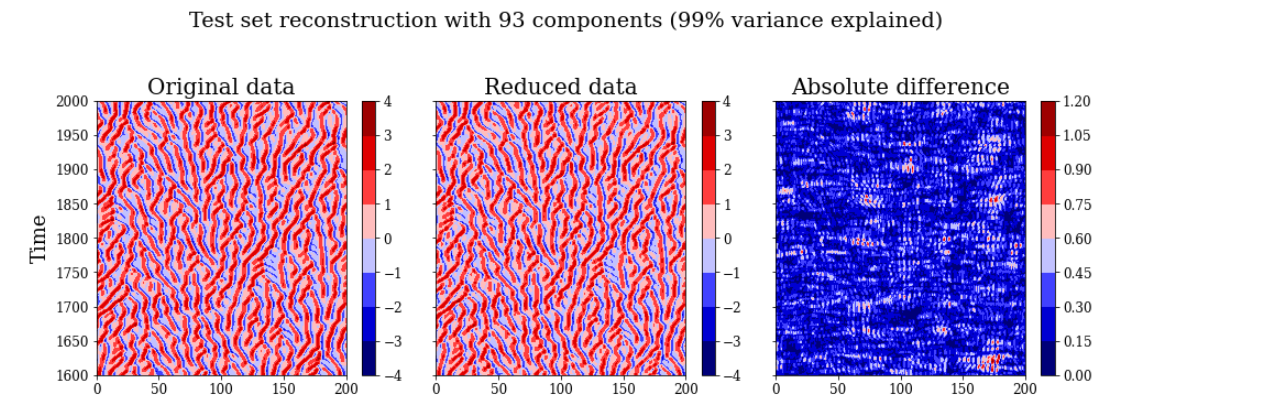


Não foi necessário usar um RNN ou LSTM para conseguir modelar as 93 séries temporais. Não vejo motivo em testar redes neurais visto a precisão do resultado